In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from os import getcwd, path
import os
import math
import shutil

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

from official.nlp import optimization
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks
tfds.disable_progress_bar()


from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from textaugment import EDA
import nltk
import random
from random import shuffle
random.seed(1)

import matplotlib.pyplot as plt

from collections import defaultdict

import xgboost as xgb

from re import compile
import re

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

plt.style.use('ggplot')





KeyboardInterrupt: 

# 1. Parameters

In [2]:
# Hyperparameters
text_cleaning = True
use_tfidf_tokenizer = False 
use_keras_tokenizer = True
use_pretrained_embeddings = True

# Initialize Model
epochs = 10
batch_size = 16

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
num_word = 10000

seed=123
np.random.seed(seed)

# 2. Functions

In [ ]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
    """Function to clean raw corpus text.

    Parameters
    ----------
    text : obj: numpy.array: `str`
        Corpus text, each element being a sentence

    Returns
    -------
    text: obj: numpy.array : str
        Clean text
    """
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    
    return text


def get_only_chars(line):

    clean_line = ""

    line = line.lower()
    line = line.replace(" 's", " is") 
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.replace("'", "")

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    #print(clean_line)
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

def text_augmentation_synonym(sentence, alpha_sr=0.1, num_aug=10):
    """
    Generate Synonyms sentences for a given sentence

    alpha: percentage of words to be synonymized in a sentence

    """

    sentence = get_only_chars(sentence)  # ["This is a house "]
    words = sentence.split(' ') # ["This",  "is", "a", "house", ""]
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1

    if (alpha_sr > 0):

        n_sr = max(1, int(alpha_sr*num_words))

        for random_state in range(num_aug):

            t = EDA(random_state = random_state)

            a_words = t.synonym_replacement(sentence, n_sr)

            a_words = ''.join(a_words)

            # only append if not already available
            if not a_words in augmented_sentences:

                augmented_sentences.append(a_words)


    return augmented_sentences

def create_corpus_augmented(corpus, alpha_sr, num_aug, verbose = 0 ):
    """
    This function takes every sentence in the corpus and generates
    synonym sentece give by the parameter num_aug. The number of words
    in each sentence to be synonymized is controlled by the parameter
    alpha_sr ( 0.0 - 1.0) where 1.0 means change all the words. 

    """
    corpus_augmented = []

    for index, row in corpus.iterrows():
        
        if verbose > 1:
            print("Generating synomyms for sentence :" , row['text'] )

        new_senteces = text_augmentation_synonym(sentence = row['text'],
                            alpha_sr = alpha_sr, 
                            num_aug = num_aug) 

        new_corpus_augmented = pd.DataFrame(dict( text = new_senteces ) )

        # Add Label
        new_corpus_augmented['label'] = row['label']  

        corpus_augmented.append(new_corpus_augmented)

    return pd.concat(corpus_augmented).reset_index(drop = True)


def create_class_weight(labels_dict,mu=1.9):

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight


# 3. Data Ingest

## Use Category Data

In [ ]:
data_dir = 'data/ML_data_3.0.xlsx'
corpus = pd.read_excel(data_dir ,engine='openpyxl')

corpus = corpus[~corpus['label'].isna()][['text','label']]

 # Filter all NAs values
corpus.dropna(inplace= True)

 # Make Sure labels are integers
corpus['label'] = corpus['label'].astype(int)



corpus = corpus.sample(frac=1).reset_index(drop=True)


## Text Cleaning

In [ ]:
text_cleaning = True
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')

In [48]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2130 entries, 0 to 2129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2130 non-null   object
 1   label   2130 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 25.1+ KB



## Text Augmentation

In [48]:
# Augment Corpus 
augmented_corpus = create_corpus_augmented(corpus = corpus, alpha_sr = 0.05, num_aug = 8)

In [8]:
# Add new senteces to original corpus
corpus = pd.concat([corpus, augmented_corpus]).reset_index(drop = True)

In [16]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17906 entries, 0 to 17905
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17906 non-null  object
 1   label   17906 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.9+ KB


## Class Weights

In [6]:
# labels_dict
labels_dict = {0: len(corpus[corpus['label']==0]), 1: len(corpus[corpus['label']==1]), 2: len(corpus[corpus['label']==2]), 3: len(corpus[corpus['label']==3]), 4: len(corpus[corpus['label']==4])}

create_class_weight(labels_dict)

{0: 1.0,
 1: 3.4229292222894947,
 2: 3.3569712544976973,
 3: 3.1466758456613366,
 4: 3.085375319797541}

# 4. Prepare Trainig and Test data

In [93]:

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(corpus['text'],
    batch_size=batch_size,
    validation_split=0.25,
    subset='training',
    seed=seed
    )

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    corpus['text'],
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

TypeError: listdir: path should be string, bytes, os.PathLike or None, not Series

In [19]:
# Get training X data
#sentences = corpus['text'].values

# Use Label encoder for the expected output
#Encoder = LabelEncoder()
#encoded_Y = Encoder.fit_transform(corpus['label'].values)
#Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( corpus['text'],corpus['label'], test_size=0.25, stratify=corpus['label'])

Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=5, dtype='float32')
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes=5, dtype='float32')


#output_label = len(np.unique(encoded_Y))


# 5. Word Tokenizer 

# 6. Embeddings

## Use pre-trained Embedding Space ( GloVe )

# 6. Model - BERT 

In [7]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' #medium sized bert

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [9]:
classifier_model = build_classifier_model()

In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [20]:
epochs = 5
steps_per_epoch = (len(sentences_train)/8)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'pooled_output': (N 109482241   preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

In [22]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=sentences_train, y=Y_train,
                               validation_split=0.2,
                               batch_size=8,
                               epochs=epochs,
                               class_weight=create_class_weight(labels_dict),
                               )



Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5


InvalidArgumentError:  Trying to access resource using the wrong type. Expected class tensorflow::lookup::LookupInterface got class tensorflow::lookup::LookupInterface
	 [[{{node model/preprocessing/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_tokenizer/StatefulPartitionedCall/WordpieceTokenizeWithOffsets/WordpieceTokenizeWithOffsets/WordpieceTokenizeWithOffsets}}]] [Op:__inference_train_function_147009]

Function call stack:
train_function


## Prediction

In [ ]:
Y_pred = model.predict(X_test)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

# Metrics

In [ ]:
print ('MSE:',loss)
print ('MAE:',accuracy)
print ('r2:',r2_score(Y_test, Y_pred))
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

In [20]:
from os.path import join

from sys import path
path.append( join( join( getcwd() , 'functions/' ) ) )

from functions import preprocessing, modelling, postprocessing
from config import ConfigDict

import openpyxl
from sklearn import feature_selection

# temp
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
import datetime
timestamp = datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S")


In [48]:
from keras.models import load_model


In [49]:
output_vectorizer = "results/vectorizer"
file_name = "keras_vectorizer_012345"

postprocessing.store_to_pickle(tokenizer, output_vectorizer, timestamp, file_name )

output_model = os.path.join("results/model",f"{timestamp}_CNN_weighted_classes.h5")
model.save(output_model)
loaded_model = load_model(output_model)

## Load Models 

In [78]:
sentences = pd.DataFrame( dict(text = pd.read_excel( "C:/Repositories/Results.xlsx",  engine='openpyxl')['text']))


In [93]:
if text_cleaning:

    sentences = sentences.reset_index(drop=True)
    
    sentences['text'] = sentences['text'].apply(lambda x: re.sub( r'[+-]?([0-9]*[.])?[0-9]+', '', str(x)))
    sentences['text'] = sentences['text'].apply(clean_text)
    

In [95]:
if use_nltk_cleaning:

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        sentences['text'] = [sent_tokenize(x) for x in sentences['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        sentences['text'] = [word_tokenize(x) for x in sentences['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(sentences['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        sentences.loc[index,'text_clean'] = ' '.join(lemma_words)
    
    sentences.loc[:,'text'] = sentences['text_clean']

In [125]:
loaded_keras_tokenizer = postprocessing.load_pickle(output_path = output_vectorizer , 
                                    timestamp = timestamp , 
                                    file_name = file_name)

CNN_model =  loaded_model = load_model(output_model)

new_sentence_train = loaded_keras_tokenizer.texts_to_sequences(sentences['text']) 

new_sentence_train = pad_sequences(new_sentence_train, padding='post', maxlen=seq_input_len)

In [127]:
Y_pred = CNN_model.predict(new_sentence_train)
Y_label = []

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            Y_label.append(index)
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [129]:
sentences['label'] = Y_label

In [130]:
sentences.head()

,text,text_clean,label
0,procure raw material variety supplier around w...,procure raw material variety supplier around w...,1
1,generally seek obtain material region product ...,generally seek obtain material region product ...,1
2,significant raw material use manufacture produ...,significant raw material use manufacture produ...,1
3,december eperiencedany significant shortage ra...,december eperiencedany significant shortage ra...,1
4,commodity cost volatility notably relate coppe...,commodity cost volatility notably relate coppe...,0


In [131]:
sentences['label'].unique()

array([1, 0, 4, 2, 3], dtype=int64)

In [132]:
sentences[['text','label']].to_excel(r'C:/Repositories/Classifications_5300.xlsx', index = False)

In [30]:
y = Y_train
X_names = loaded_keras_tokenizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:30]))
   print(" ")

AttributeError: 'Tokenizer' object has no attribute 'get_feature_names'

## 4.1 CNN with TFIDF

In [59]:
# Principal Component Analysis - Para reducir dimensionalidad 

In [68]:
embedding_dim

300

In [69]:
vocab_size

3487

In [37]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=X_train_Tfidf.shape[1]))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 256, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 3630, 300)         1089300   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3629, 256)         153856    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 3627, 32)          24608     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
Total params: 1,268,149
Trainable params: 1,268,149
Non-trainable params: 0
____________________________________________

Wall time: 0 ns
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping
Training Accuracy: 0.7057
Testing Accuracy:  0.6961


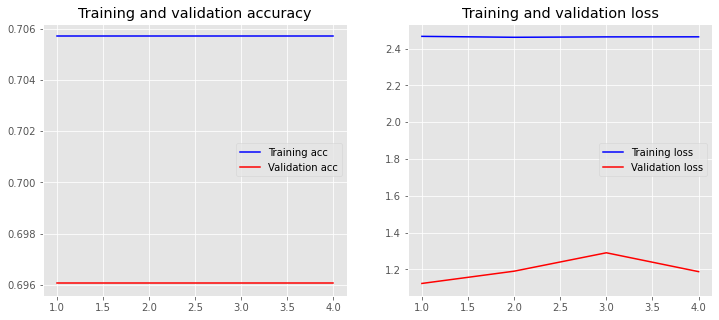

In [39]:
%time

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)


history = model.fit(X_train_Tfidf, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_Tfidf, Y_test),
                    batch_size = batch_size , class_weight = create_class_weight(labels_dict), callbacks = callback)

loss, accuracy = model.evaluate(X_train_Tfidf, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_Tfidf, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 7. Run Model - Recurrent Neural Networks - RNN

Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [212]:
del model

In [213]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='softmax'))
model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [218]:
epochs

10

Epoch 1/10
6/6 [==============================] - 3s 488ms/step - loss: 0.2653 - accuracy: 0.7642 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 2/10
6/6 [==============================] - 3s 476ms/step - loss: 0.2680 - accuracy: 0.7583 - val_loss: 0.5647 - val_accuracy: 0.7483
Epoch 3/10
6/6 [==============================] - 3s 462ms/step - loss: 0.2690 - accuracy: 0.7591 - val_loss: 0.5648 - val_accuracy: 0.7483
Epoch 4/10
6/6 [==============================] - 3s 470ms/step - loss: 0.2665 - accuracy: 0.7583 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 5/10
6/6 [==============================] - 3s 458ms/step - loss: 0.2641 - accuracy: 0.7731 - val_loss: 0.5661 - val_accuracy: 0.7483
Training Accuracy: 0.7713
Testing Accuracy:  0.7908


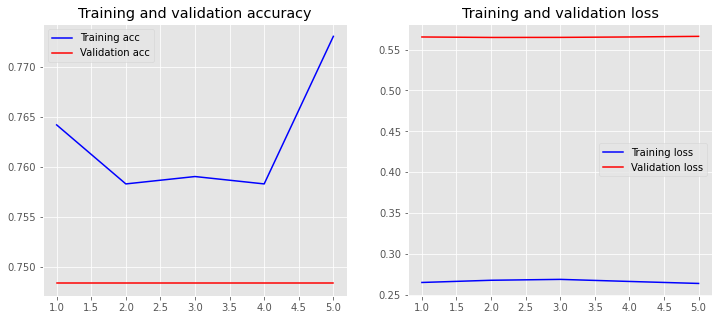

In [242]:
# train_x = np.asarray(X_train_keras)
# train_y = np.asarray(Y_train)
# validation_x = np.asarray(X_test_keras)
# validation_y = np.asarray(Y_test)
class_weight = {0: 0.25,
                1: 0.75}z


history = model.fit(X_train_keras, 
                    Y_train, 
                    epochs = 10, 
                    batch_size = batch_size,
                    validation_data = (X_test_keras, Y_test), 
                    validation_split=0.1,
                    verbose = True,
                    class_weight= class_weight,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [243]:
Y_pred = model.predict(X_test_keras)

In [244]:
for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [245]:
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  93.16  %
Accuracy for label 1 :  35.25  %


{0: 93.16, 1: 35.25}

## 8. GRU NN

In [246]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()


if use_pretrained_embeddings:  
  
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
gru_model.add(layers.GRU(32, return_sequences=False))
gru_model.add(layers.Dropout(0.5))
#gru_model.add(layers.Dense(10, activation='softmax'))
gru_model.add(layers.Dense(output_label, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 50, 300)           1051800   
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                32064     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 66        
Total params: 1,083,930
Trainable params: 32,130
Non-trainable params: 1,051,800
_________________________________________________________________
None


In [247]:
train_x = np.asarray(X_train_keras)
train_y = np.asarray(Y_train)
validation_x = np.asarray(X_test_keras)
validation_y = np.asarray(Y_test)

In [248]:
class_weight = {0: 0.25,
                1: 0.75}

history = gru_model.fit(train_x, 
                    train_y, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (validation_x, validation_y), 
                    class_weight = class_weight)

Epoch 1/10
6/6 [==============================] - 4s 226ms/step - loss: 0.2716 - accuracy: 0.4068 - val_loss: 0.7003 - val_accuracy: 0.2430
Epoch 2/10
6/6 [==============================] - 1s 111ms/step - loss: 0.2688 - accuracy: 0.2766 - val_loss: 0.7056 - val_accuracy: 0.2430
Epoch 3/10
6/6 [==============================] - 1s 108ms/step - loss: 0.2707 - accuracy: 0.2832 - val_loss: 0.7115 - val_accuracy: 0.2430
Epoch 4/10
6/6 [==============================] - 1s 105ms/step - loss: 0.2691 - accuracy: 0.2786 - val_loss: 0.7177 - val_accuracy: 0.2430
Epoch 5/10
6/6 [==============================] - 1s 112ms/step - loss: 0.2679 - accuracy: 0.2755 - val_loss: 0.7229 - val_accuracy: 0.2430
Epoch 6/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2676 - accuracy: 0.2740 - val_loss: 0.7270 - val_accuracy: 0.2430
Epoch 7/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2738 - accuracy: 0.2956 - val_loss: 0.7313 - val_accuracy: 0.2430
Epoch 8/10
6/6 [====

In [249]:

train_gru_results = gru_model.evaluate(train_x, train_y, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(validation_x, validation_y, verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 27.66
Test accuracy: 24.30


In [250]:
Y_pred = gru_model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  0.0  %
Accuracy for label 1 :  100.0  %


{0: 0.0, 1: 100.0}